# Challenge 3

In [53]:
%load_ext autotime

## Preprocessing

In [54]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
import os
from imutils import paths
%matplotlib inline

time: 18.1 ms


In [55]:
def processImage(im, desired_size, debug=False):
    # get old size
    old_size = im.size 
    # detect the ratio to which we need to scale the image
    ratio = float(desired_size)/max(old_size)
    # detect the new size of the image to fit the square box
    new_size = tuple([int(x*ratio) for x in old_size])
    # resize to new size
    im = im.resize(new_size, Image.ANTIALIAS)
    # define background color
    bgcolor = 0xffffff
    # create new blank image and "paste" the resized image in the middle of it
    new_im = Image.new("RGB", (desired_size, desired_size), bgcolor)
    new_im.paste(im, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
    
    # do color equalization
    arr = Image.fromarray(np.uint8(new_im))
    new_im = ImageOps.equalize(arr)
    return new_im

time: 21.7 ms


In [56]:
def load(imagePaths, verbose = -1):
    data = []
    labels = []

    #loop over input images
    for (i, imagePath) in enumerate(imagePaths):
        # assumes our path has the following format:
        # /path/to/dataset/{class}/{image}.jpg
        image = Image.open(imagePath)
        label = imagePath.split(os.path.sep)[-2]
        
        #preprocess
        image = processImage(image, 128)
        
        data.append(np.asarray(image))
        labels.append(label)

        # show an update every 'verbose' images
        if verbose > 0 and i > 0 and (i+1) % verbose == 0:
            print('[INFO] processed {}/{}'.format(i + 1, len(imagePaths)))
        
    return (np.array(data), np.array(labels))

time: 18.5 ms


In [57]:
imagePaths = list(paths.list_images('gear_images'))
(data, labels) = load(imagePaths, verbose=100)

print("Before reshaping: ", data.shape)
size = 128 * 128 * 3
data = data.reshape(data.shape[0], size)
print("After reshaping: ", data.shape)

[INFO] processed 100/2122
[INFO] processed 200/2122
[INFO] processed 300/2122
[INFO] processed 400/2122
[INFO] processed 500/2122
[INFO] processed 600/2122
[INFO] processed 700/2122
[INFO] processed 800/2122
[INFO] processed 900/2122
[INFO] processed 1000/2122
[INFO] processed 1100/2122
[INFO] processed 1200/2122
[INFO] processed 1300/2122
[INFO] processed 1400/2122
[INFO] processed 1500/2122
[INFO] processed 1600/2122
[INFO] processed 1700/2122
[INFO] processed 1800/2122
[INFO] processed 1900/2122
[INFO] processed 2000/2122
[INFO] processed 2100/2122
Before reshaping:  (2122, 128, 128, 3)
After reshaping:  (2122, 49152)
time: 10.3 s


In [58]:
data.shape

(2122, 49152)

time: 2.91 ms


In [59]:
labels.shape

(2122,)

time: 16.9 ms


In [60]:
type(data)

numpy.ndarray

time: 16 ms


In [61]:
type(labels)

numpy.ndarray

time: 14.6 ms


## Modelling

### Encode Labels

In [62]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
encoded_labels = le.fit_transform(labels)

print(le.classes_)
print(encoded_labels)

['axes' 'boots' 'carabiners' 'crampons' 'gloves' 'hardshell_jackets'
 'harnesses' 'helmets' 'insulated_jackets' 'pulleys' 'rope' 'tents']
[1 1 1 ... 0 0 0]
time: 19.5 ms


### Split Data

In [63]:
from sklearn.model_selection import train_test_split

data_train, data_test, label_train, label_test = train_test_split(data, encoded_labels, test_size=0.3, random_state=1)

print(data_train.shape)
print(label_train.shape)
print(data_test.shape)
print(label_test.shape)

(1485, 49152)
(1485,)
(637, 49152)
(637,)
time: 43.7 ms


### Train model

In [65]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)
model.fit(data_train, label_train) 

pred_knn = model.predict(data_test)

time: 1min 39s


In [66]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=1)
model.fit(data_train, label_train) 

pred_tree = model.predict(data_test)

time: 3.78 s


### Score model

In [67]:
from sklearn.metrics import accuracy_score

print(accuracy_score(label_test, pred_knn))
print(accuracy_score(label_test, pred_tree))

0.9058084772370487
0.8948194662480377
time: 3.68 ms


### Confusion Matrix

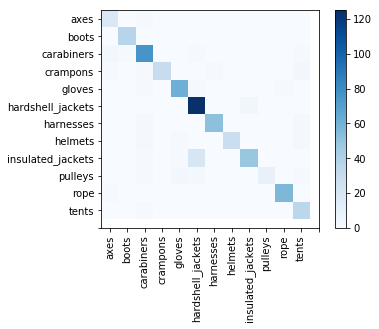

time: 254 ms


In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

columns = le.classes_
confusion = confusion_matrix(label_test, pred_knn)

plt.imshow(confusion, cmap=plt.cm.Blues, interpolation='nearest')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12], columns, rotation='vertical')
plt.yticks([0,1,2,3,4,5,6,7,8,9,10,11,12], columns)
plt.colorbar()

plt.show()


### Full Report

In [69]:
import sklearn.metrics as metrics

target_names = le.classes_
print(metrics.classification_report(label_test, pred_knn, target_names=target_names))

                   precision    recall  f1-score   support

             axes       0.78      0.95      0.86        19
            boots       0.97      1.00      0.99        37
       carabiners       0.88      0.93      0.90        82
         crampons       1.00      0.83      0.91        36
           gloves       0.93      0.95      0.94        65
hardshell_jackets       0.84      0.97      0.90       129
        harnesses       0.98      0.93      0.95        56
          helmets       1.00      0.85      0.92        33
insulated_jackets       0.92      0.69      0.79        70
          pulleys       1.00      0.56      0.72        16
             rope       0.98      0.98      0.98        58
            tents       0.80      0.97      0.88        36

      avg / total       0.91      0.91      0.90       637

time: 4.11 ms


### Score best model against a different dataset

In [70]:
! curl https://shop.epictv.com/sites/default/files/ae42ad29e70ba8ce6b67d3bdb6ab5c6e.jpeg -O
! mv ae42ad29e70ba8ce6b67d3bdb6ab5c6e.jpeg test.jpeg
! ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  167k  100  167k    0     0   741k      0 --:--:-- --:--:-- --:--:--  744k
total 500
-rw-rw-r--  1 ikos ikos 182035 May 31 07:56 Challenge 0.ipynb
-rw-rw-r--  1 ikos ikos   2880 May 30 13:20 Challenge 1.ipynb
-rw-rw-r--  1 ikos ikos 120077 May 30 14:45 Challenge 2.ipynb
-rw-rw-r--  1 ikos ikos  11940 May 31 09:39 Challenge 3.ipynb
drwxrwxr-x 14 ikos ikos   4096 May 30 10:42 gear_images
-rw-rw-r--  1 ikos ikos   1074 May 30 13:11 LICENSE
-rw-rw-r--  1 ikos ikos     38 May 30 13:11 README.md
drwxrwxr-x  2 ikos ikos   4096 May 31 08:01 Source
-rw-rw-r--  1 ikos ikos 171537 May 31 09:41 test.jpeg
time: 622 ms


In [71]:
rt_data = []
rt_image = Image.open("test.jpeg")

rt_image = processImage(rt_image, 128)
rt_data.append(np.asarray(rt_image))

rt_data = np.array(rt_data)

print("Before reshaping: ", rt_data.shape)
size = 128 * 128 * 3
rt_data = rt_data.reshape(1, size)
print("After reshaping: ", rt_data.shape)

rt_pred_knn = model.predict(rt_data)

Before reshaping:  (1, 128, 128, 3)
After reshaping:  (1, 49152)
time: 155 ms


In [72]:
print(accuracy_score(label_test, pred_knn))
print(rt_pred_knn)
print(le.classes_[rt_pred_knn])

0.9058084772370487
[7]
['helmets']
time: 2.95 ms
